<a href="https://colab.research.google.com/github/Jeevesh28/TrueFoundry_Sentiment_Analysis_API/blob/main/model_approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### A. Importing Libraries:

1. Basic Data Science

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Pastel2', style='dark')
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS
import random
import string
import re

2. Natural Language Toolkit

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


3. Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import torch
from torch.utils.data import TensorDataset, RandomSampler,SequentialSampler,DataLoader

4. Deep learning and Transformers

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras import losses
from keras.preprocessing.text import Tokenizer, one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.metrics import Precision, Recall
from keras.callbacks import LearningRateScheduler, History
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

#### B. Data Cleaning and Exploration:

In [ ]:
df = pd.read_csv('airline_sentiment_analysis.csv', index_col = 0)
df.reset_index(inplace = True, drop = True)
df.head()

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
print(f'Shape of the dataframe is {df.shape}')
print(f'Percentage null or na values in df {((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)}')

Shape of the dataframe is (11541, 2)
Percentage null or na values in df airline_sentiment    0.0
text                 0.0
dtype: float64


1. Removing @'Flight_Name' and storing 'Flight_name' in new column

In [ ]:
df['airline'] = ''
df['airline'] = df['text'].str.findall(r'@([a-zA-Z0-9_]{1,50})').str[0].str.lower()
df['text'] = df['text'].str.replace(r'@[A-Za-z0-9_]+', '', regex=True).astype(str)
df.head()

,airline_sentiment,text,airline
0,positive,plus you've added commercials to the experien...,virginamerica
1,negative,"it's really aggressive to blast obnoxious ""en...",virginamerica
2,negative,and it's a really big bad thing about it,virginamerica
3,negative,seriously would pay $30 a flight for seats th...,virginamerica
4,positive,"yes, nearly every time I fly VX this “ear wor...",virginamerica


2. Mapping Sentiment into numerical values (Positive -> 0 and Negative -> 1)

In [ ]:
possible_label = df.airline_sentiment.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index

print(dict_label)

df['Label'] = df['airline_sentiment'].replace(dict_label)
df.head()

{'positive': 0, 'negative': 1}


,airline_sentiment,text,airline,Label
0,positive,plus you've added commercials to the experien...,virginamerica,0
1,negative,"it's really aggressive to blast obnoxious ""en...",virginamerica,1
2,negative,and it's a really big bad thing about it,virginamerica,1
3,negative,seriously would pay $30 a flight for seats th...,virginamerica,1
4,positive,"yes, nearly every time I fly VX this “ear wor...",virginamerica,0


3. Data Visualisations

In [ ]:
RED = '#FF0000'
GREEN = '#00FF00'

In [ ]:
print(df['airline_sentiment'].value_counts())

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


In [ ]:
print(df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)[:6])

airline
united           3121
usairways        2525
americanair      2293
southwestair     1755
jetblue          1494
virginamerica     333
Name: airline_sentiment, dtype: int64


* Countplot of number of Positive and Negative tweets

Text(0, 0.5, 'Number of Tweets')

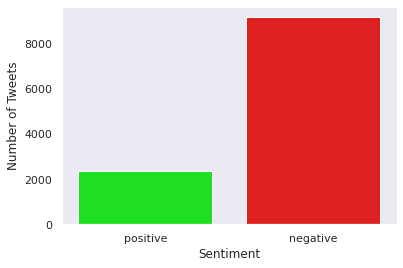

In [ ]:
f, ax = plt.subplots()
ax = sns.countplot(x='airline_sentiment', data=df, palette=[GREEN, RED])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets');

* Airline wise Positive and Negative tweets

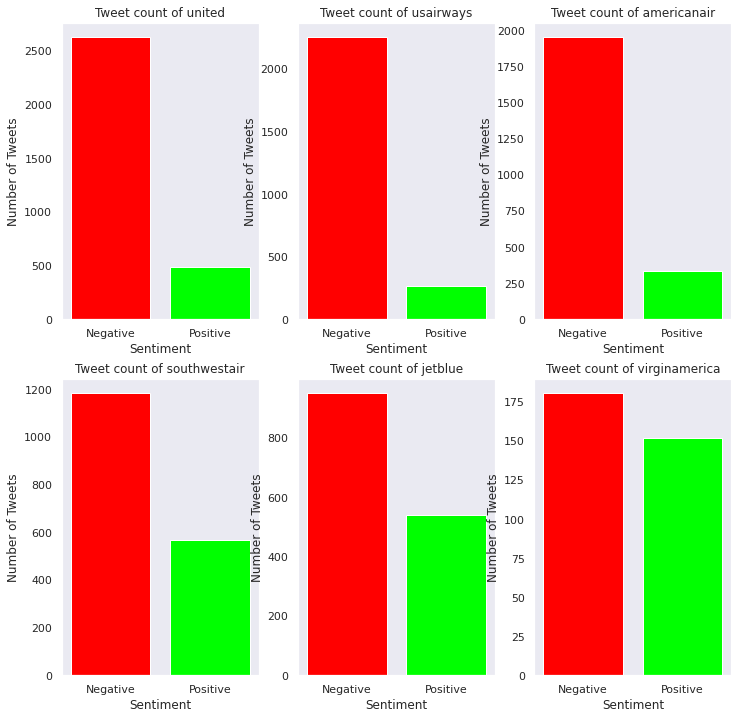

In [ ]:
airlines= ['united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'virginamerica']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df = df[df['airline']==i]
    count = new_df['airline_sentiment'].value_counts()
    Index = [1,2]
    plt.bar(Index,count, color=[RED, GREEN])
    plt.xticks(Index,['Negative', 'Positive'])
    plt.ylabel('Number of Tweets')
    plt.xlabel('Sentiment')
    plt.title('Tweet count of ' + i)

* Most common Hashtags (#)

In [ ]:
words = [w for word in df.text.values for w in word.split()]
hashtags = [h for h in words if h.startswith('#')]
counter_hash = Counter(hashtags)
counter_hash.most_common()[0:20]

[('#', 77),
 ('#fail', 52),
 ('#jetblue', 33),
 ('#customerservice', 32),
 ('#UnitedAirlines', 29),
 ('#usairwaysfail', 25),
 ('#DestinationDragons', 24),
 ('#AmericanAirlines', 21),
 ('#disappointed', 19),
 ('#badservice', 19),
 ('#neveragain', 17),
 ('#united', 15),
 ('#usairways', 15),
 ('#frustrated', 14),
 ('#help', 14),
 ('#badcustomerservice', 14),
 ('#USAirways', 14),
 ('#travel', 12),
 ('#nothappy', 11),
 ('#unitedairlines', 10)]

In [ ]:
emoticons_str = [':D', ':/', ':)', ':(', ':]', ':[', 'Oo']
emoticons = [word for word in words if word in emoticons_str]
Counter(emoticons).most_common()[0:10]

[(':)', 114), (':(', 75), (':/', 15), (':D', 8)]

In [ ]:
def has_emoticon(x):
    words = x.split()
    negative_emoticons = [':/', ':(', ':[', 'D:']
    positive_emoticons = [':)', ':D', ':]']

    neg = [word for word in words if word in negative_emoticons]
    pos = [word for word in words if word in positive_emoticons]

    if len(neg) > len(pos):
        return 'emoticon_negative'
    elif len(pos) > len(neg):
        return 'emoticon_positive'
    else:
        return 'emoticon_neutral'

df['emoticon_sentiment'] = df.text.apply(lambda x: has_emoticon(x))

* Emoticon Sentiment

Text(0, 0.5, 'Number of Tweets')

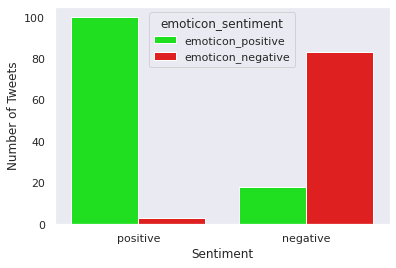

In [ ]:
f, ax = plt.subplots()
ax = sns.countplot(x='airline_sentiment', hue='emoticon_sentiment', data=df[df.emoticon_sentiment!='emoticon_neutral'], palette=[GREEN, RED])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets');

In [ ]:
df.groupby(['airline_sentiment', 'emoticon_sentiment']).size()

airline_sentiment  emoticon_sentiment
negative           emoticon_negative       83
                   emoticon_neutral      9077
                   emoticon_positive       18
positive           emoticon_negative        3
                   emoticon_neutral      2260
                   emoticon_positive      100
dtype: int64

In [ ]:
positive_tweets = df[df.airline_sentiment == 'positive']['text'].values
negative_tweets = df[df.airline_sentiment == 'negative']['text'].values

positive_tweets = [w for tweet in positive_tweets for w in word_tokenize(tweet)]
negative_tweets = [w for tweet in negative_tweets for w in word_tokenize(tweet)]

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via'] +['united', 'usairways','southwestair', 'americanair', 'jetblue', 'http', '\'s', 'virginamerica']

* Most common Positive words

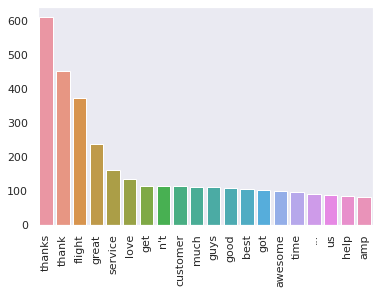

In [ ]:
terms_positive = [term.lower() for term in positive_tweets if term.lower() not in stop]
count_terms = Counter(terms_positive)

f, ax = plt.subplots()
sns.barplot(list(list(zip(*count_terms.most_common()[0:20]))[0]), list(list(zip(*count_terms.most_common()[0:20]))[1]));

for tick in ax.get_xticklabels():
  tick.set_rotation(90)

* Most common Negative words

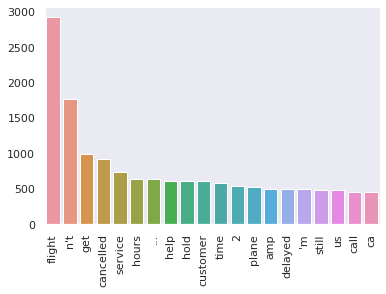

In [ ]:
terms_negative = [term.lower() for term in negative_tweets if term.lower() not in stop]
count_terms = Counter(terms_negative)

f, ax = plt.subplots()
sns.barplot(list(list(zip(*count_terms.most_common()[0:20]))[0]), list(list(zip(*count_terms.most_common()[0:20]))[1]))

for tick in ax.get_xticklabels():
  tick.set_rotation(90)

#### C. Data Processing:

1. Normalising into words or Normalising into Tokens

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
  text = re.sub(r"http:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", tweet)
  only_letters = re.sub("[^a-zA-Z]", " ",text) 
  tokens = nltk.word_tokenize(only_letters)[:] 
  lower_case = [l.lower() for l in tokens]
  lemmas = [wordnet_lemmatizer.lemmatize(t) for t in lower_case]
  return ' '.join(lemmas)
   
def normalizer2(tweet):
  text = re.sub(r"http:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", tweet)
  only_letters = re.sub("[^a-zA-Z]", " ",text) 
  tokens = nltk.word_tokenize(only_letters)[:]
  lower_case = [l.lower() for l in tokens]
  filtered_result = list(filter(lambda l: l not in stop, lower_case))
  lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
  return lemmas

df['normalized_tweet'] = df.text.apply(normalizer)
df['normalized_tweet_tokens'] = df.text.apply(normalizer2)

2. Creating n-grams

In [ ]:
def ngrams(input_list):
  onegrams = input_list
  bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
  trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
  return bigrams + trigrams
  
df['grams'] = df.normalized_tweet_tokens.apply(ngrams)

In [ ]:
def count_words(input):
  cnt = Counter()
  for row in input:
    for word in row:
      cnt[word] += 1
  return cnt

def column(matrix, i):
  return [row[i] for row in matrix]

In [ ]:
positivewords = df[(df.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(50)
negativewords = df[(df.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(50)

positiveword = ' '.join(column(positivewords, 0))
negativeword = ' '.join(column(negativewords, 0))

3. WordCloud of Positive words

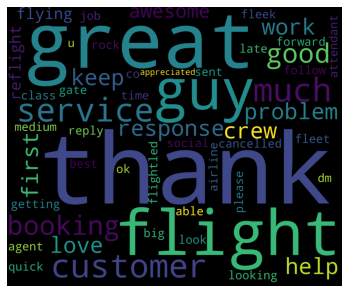

In [ ]:
wordcloud  = WordCloud(stopwords=STOPWORDS, background_color='black', width=3000, height=2500).generate(positiveword)
plt.figure(1,figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

4. WordCloud of Negative words

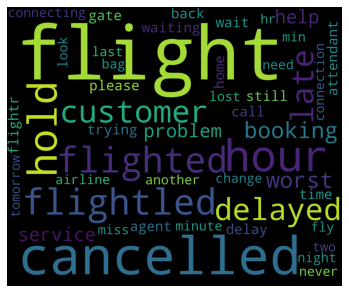

In [ ]:
wordcloud  = WordCloud(stopwords=STOPWORDS, background_color='black', width=3000, height=2500).generate(negativeword)
plt.figure(1,figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### D. Models:

##### 1. Machine Learning

In [ ]:
def check_scores(clf,X_train, X_test, y_train, y_test):
  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))
  print()

  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()

  print(classification_report(y_test,predicted_class)) 
  print()

  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()

  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5, bottom=0.1, right=1.5, top=0.9, wspace=0.4, hspace=0.4)
  print()
  print('Area under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)

  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose=1, scoring='roc_auc')
  grid.fit(X_train,Y_train)
  optimal_model = grid.best_estimator_
  print()
  print('Best parameters are: ')
  print( grid.best_params_)
  return optimal_model

* TF-IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.normalized_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df.Label.values, test_size = 0.2, random_state = 42)

* SVM (Support-Vector Machine)

Train confusion matrix is: 
[[1819   97]
 [   5 7311]]

Test confusion matrix is: 
[[ 272  175]
 [  25 1837]]

              precision    recall  f1-score   support

           0       0.92      0.61      0.73       447
           1       0.91      0.99      0.95      1862

    accuracy                           0.91      2309
   macro avg       0.91      0.80      0.84      2309
weighted avg       0.91      0.91      0.91      2309


Train accuracy score:  0.9889514731369151
Test accuracy score:  0.913382416630576

Train ROC-AUC score:  0.9996334213569138
Test ROC-AUC score:  0.9569982001984829

Area under Precision-Recall curve: 0.9483737738771296
Area under ROC-AUC: 0.9880713202343421


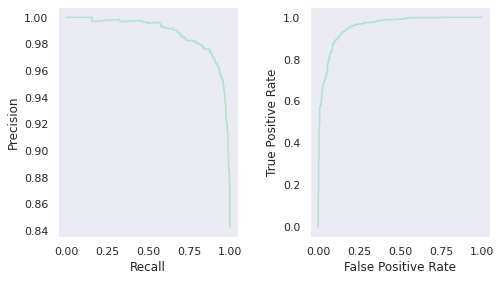

In [ ]:
SVM = svm.SVC(probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

In [ ]:
parameters ={"C":[0.1,1,10], "kernel":['linear', 'rbf', 'sigmoid'], "gamma":['scale', 'auto']}
svm_optimal = grid_search(svm.SVC(probability=True), parameters, x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits

Best parameters are: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Train confusion matrix is: 
[[1912    4]
 [   1 7315]]

Test confusion matrix is: 
[[ 303  144]
 [  39 1823]]

              precision    recall  f1-score   support

           0       0.89      0.68      0.77       447
           1       0.93      0.98      0.95      1862

    accuracy                           0.92      2309
   macro avg       0.91      0.83      0.86      2309
weighted avg       0.92      0.92      0.92      2309


Train accuracy score:  0.9994584055459272
Test accuracy score:  0.920744911216977

Train ROC-AUC score:  0.9999991082547361
Test ROC-AUC score:  0.9577503201916584

Area under Precision-Recall curve: 0.9522068425176287
Area under ROC-AUC: 0.9884485805218046


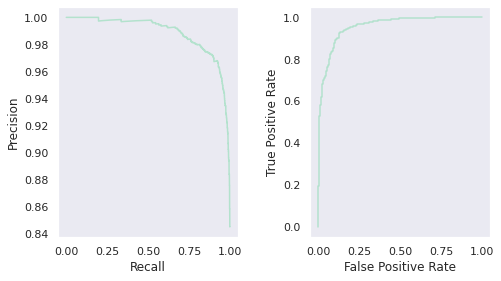

In [ ]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal, x_train, x_test, y_train, y_test)

* MultinomialNB (Multinomial Naive Bayes)

Train confusion matrix is: 
[[ 593 1323]
 [   4 7312]]

Test confusion matrix is: 
[[ 103  344]
 [   4 1858]]

              precision    recall  f1-score   support

           0       0.96      0.23      0.37       447
           1       0.84      1.00      0.91      1862

    accuracy                           0.85      2309
   macro avg       0.90      0.61      0.64      2309
weighted avg       0.87      0.85      0.81      2309


Train accuracy score:  0.8562608318890814
Test accuracy score:  0.8492854049372023

Train ROC-AUC score:  0.9659838775309872
Test ROC-AUC score:  0.9301609729020537

Area under Precision-Recall curve: 0.9143700787401575
Area under ROC-AUC: 0.9806615342373278


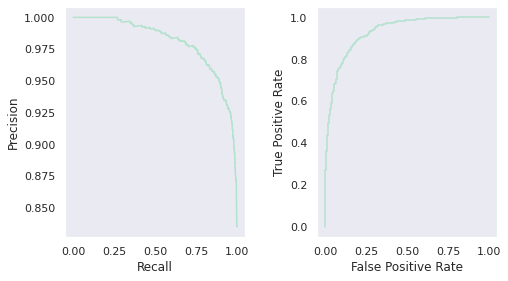

In [ ]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(), x_train, x_test, y_train, y_test)

* GaussianNB (Gaussian Naive Bayes)

Train confusion matrix is: 
[[1916    0]
 [1704 5612]]

Test confusion matrix is: 
[[ 303  144]
 [ 613 1249]]

              precision    recall  f1-score   support

           0       0.33      0.68      0.44       447
           1       0.90      0.67      0.77      1862

    accuracy                           0.67      2309
   macro avg       0.61      0.67      0.61      2309
weighted avg       0.79      0.67      0.70      2309


Train accuracy score:  0.8154246100519931
Test accuracy score:  0.6721524469467302

Train ROC-AUC score:  0.8835429196282121
Test ROC-AUC score:  0.6743182260541094

Area under Precision-Recall curve: 0.7674347158218126
Area under ROC-AUC: 0.9164464916102315


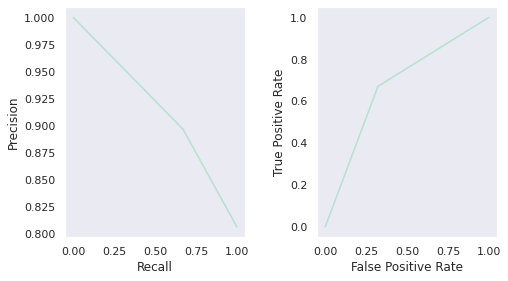

In [ ]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(), x_train.toarray(), x_test.toarray(), y_train, y_test)

* AdaBoostClassifier (Adaptive Boosting)

Train confusion matrix is: 
[[1194  722]
 [ 214 7102]]

Test confusion matrix is: 
[[ 258  189]
 [  61 1801]]

              precision    recall  f1-score   support

           0       0.81      0.58      0.67       447
           1       0.91      0.97      0.94      1862

    accuracy                           0.89      2309
   macro avg       0.86      0.77      0.80      2309
weighted avg       0.89      0.89      0.88      2309


Train accuracy score:  0.8986135181975736
Test accuracy score:  0.89172802078822

Train ROC-AUC score:  0.9265738376492854
Test ROC-AUC score:  0.8941631403532802

Area under Precision-Recall curve: 0.9350986500519213
Area under ROC-AUC: 0.9682415838119336


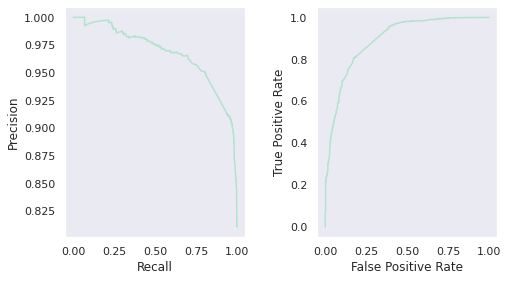

In [ ]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(), x_train, x_test, y_train, y_test)

In [ ]:
params = {'n_estimators': [10, 50, 100, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0], 'algorithm': ['SAMME', 'SAMME.R']}
ada_optimal = grid_search(AdaBoostClassifier(), params, x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits

Best parameters are: 
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}


Train confusion matrix is: 
[[1137  779]
 [ 129 7187]]

Test confusion matrix is: 
[[ 239  208]
 [  45 1817]]

              precision    recall  f1-score   support

           0       0.84      0.53      0.65       447
           1       0.90      0.98      0.93      1862

    accuracy                           0.89      2309
   macro avg       0.87      0.76      0.79      2309
weighted avg       0.89      0.89      0.88      2309


Train accuracy score:  0.9016464471403813
Test accuracy score:  0.8904287570376787

Train ROC-AUC score:  0.9553702897301763
Test ROC-AUC score:  0.9180850015739251

Area under Precision-Recall curve: 0.9349112426035503
Area under ROC-AUC: 0.9760614883332656


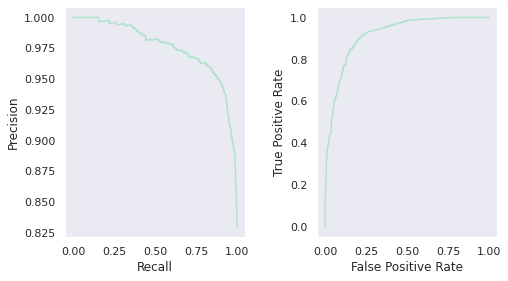

In [ ]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc = check_scores(ada_optimal, x_train, x_test, y_train, y_test)

* BaggingClassifier (Bagging with Base -> Multinomial Naive Bayes)

Train confusion matrix is: 
[[ 570 1346]
 [   6 7310]]

Test confusion matrix is: 
[[ 103  344]
 [   4 1858]]

              precision    recall  f1-score   support

           0       0.96      0.23      0.37       447
           1       0.84      1.00      0.91      1862

    accuracy                           0.85      2309
   macro avg       0.90      0.61      0.64      2309
weighted avg       0.87      0.85      0.81      2309


Train accuracy score:  0.8535528596187175
Test accuracy score:  0.8492854049372023

Train ROC-AUC score:  0.9639592590838166
Test ROC-AUC score:  0.9288549754059164

Area under Precision-Recall curve: 0.9143700787401575
Area under ROC-AUC: 0.9802290326394841


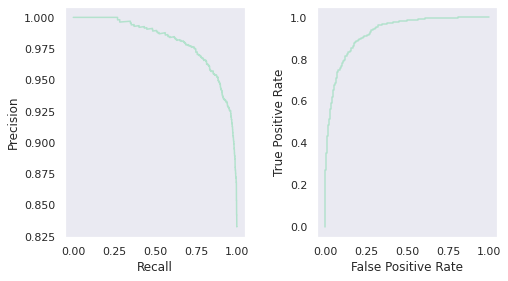

In [ ]:
model = BaggingClassifier(base_estimator = MultinomialNB(), n_estimators = 100)
b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model, x_train, x_test, y_train, y_test)

* RandomForestClassifier (Random Forest)

Train confusion matrix is: 
[[1911    5]
 [   0 7316]]

Test confusion matrix is: 
[[ 221  226]
 [  26 1836]]

              precision    recall  f1-score   support

           0       0.89      0.49      0.64       447
           1       0.89      0.99      0.94      1862

    accuracy                           0.89      2309
   macro avg       0.89      0.74      0.79      2309
weighted avg       0.89      0.89      0.88      2309


Train accuracy score:  0.9994584055459272
Test accuracy score:  0.8908618449545258

Train ROC-AUC score:  0.999999108254736
Test ROC-AUC score:  0.9291619508983389

Area under Precision-Recall curve: 0.9357798165137614
Area under ROC-AUC: 0.9783933133503264


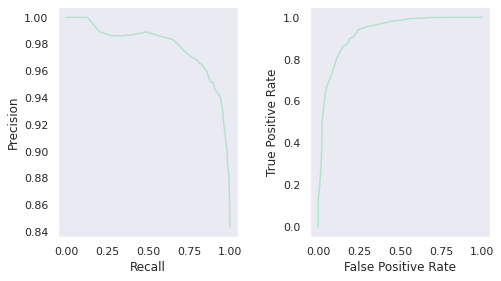

In [ ]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train, x_test, y_train, y_test)

* Results

In [ ]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc),
('Bagged MultinomialNB',b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc),
('AdaBoost',a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc ),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc),
('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
]

Scores_ = pd.DataFrame(data = data, columns=['Model Name', 'Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)
Scores_

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
Random Forest,0.999458,0.890862,0.999999,0.929162
MultinomialNB,0.856261,0.849285,0.965984,0.930161
Bagged MultinomialNB,0.853553,0.849285,0.963959,0.928855
AdaBoost,0.898614,0.891728,0.926574,0.894163
AdaBoost Optimized,0.901646,0.890429,0.955370,0.918085
Gaussian Naive Bayes,0.815425,0.672152,0.883543,0.674318
SVM,0.988951,0.913382,0.999633,0.956998
SVM Optimized,0.999458,0.920745,0.999999,0.957750


##### 2. Deep Learning

In [ ]:
max_words = 5000
max_len = 50

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization and Padding \n', df['text'][0])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization and Padding \n', X[0])

Before Tokenization and Padding 
  plus you've added commercials to the experience... tacky.
After Tokenization and Padding 
 [ 567  524 1281 2386    1    2  171    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df.Label.values, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (6924, 50) (6924,)
Validation Set -> (2308, 50) (2308,)
Test Set -> (2309, 50) (2309,)


In [ ]:
def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall + K.epsilon())
    return f1_val

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
217/217 [==============================] - 9s 16ms/step - loss: 0.4756 - accuracy: 0.8042 - precision: 0.8100 - recall: 0.9857 - val_loss: 0.4911 - val_accuracy: 0.7907 - val_precision: 0.7916 - val_recall: 0.9916
Epoch 2/20
217/217 [==============================] - 2s 10ms/step - loss: 0.4209 - accuracy: 0.8177 - precision: 0.8332 - recall: 0.9647 - val_loss: 0.4060 - val_accuracy: 0.8193 - val_precision: 0.8353 - val_recall: 0.9559
Epoch 3/20
217/217 [==============================] - 2s 10ms/step - loss: 0.3499 - accuracy: 0.8518 - precision: 0.8679 - recall: 0.9603 - val_loss: 0.3458 - val_accuracy: 0.8458 - val_precision: 0.8717 - val_recall: 0.9398
Epoch 4/20
217/217 [==============================] - 2s 10ms/step - loss: 0.2937 - accuracy: 0.8738 - precision: 0.8931 - recall: 0.9562 - val_loss: 0.2928 - val_accuracy: 0.8739 - val_precision: 0.8855 - val_recall: 0.9621
Epoch 5/20
217/217 [==============================] - 2s 10ms/step - loss: 0.2391 - accuracy: 0.9024

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9129
Precision : 0.9288
Recall    : 0.9662
F1 Score  : 0.9471


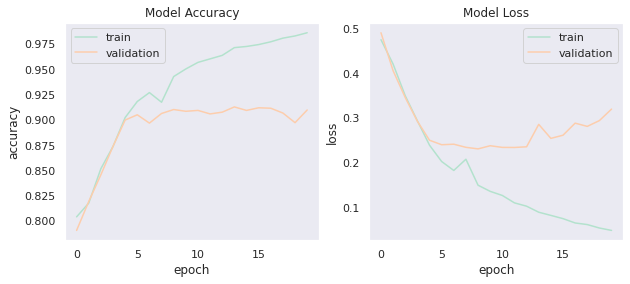

In [ ]:
def plot_training_hist(history):    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

#### 3. Transformers

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.index.values, df.Label.values, test_size = 0.15, random_state = 42,stratify = df.Label.values)

In [ ]:
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
print(' Original: ', df[df["data_type"]=='train'].text[0])
print('Tokenized: ', tokenizer.tokenize(df[df["data_type"]=='train'].text[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df[df["data_type"]=='train'].text[0])))

 Original:   plus you've added commercials to the experience... tacky.
Tokenized:  ['plus', 'you', "'", 've', 'added', 'commercials', 'to', 'the', 'experience', '.', '.', '.', 'tack', '##y', '.']
Token IDs:  [4606, 2017, 1005, 2310, 2794, 12698, 2000, 1996, 3325, 1012, 1012, 1012, 26997, 2100, 1012]


In [ ]:
max_len = 0
for sent in df[df["data_type"]=='train'].text:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length:', max_len)

Max sentence length: 57


In [ ]:
input_ids_train = []
attention_masks_train = []

for sent in df[df["data_type"]=='train'].text.values:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        truncation=True,
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',)

    input_ids_train.append(encoded_dict['input_ids'])
    attention_masks_train.append(encoded_dict['attention_mask'])
    

input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(df[df['data_type']=='train'].Label.values)


input_ids_test = []
attention_masks_test = []

for sent in df[df["data_type"]=='test'].text.values:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        truncation=True,
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',)

    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(df[df['data_type']=='test'].Label.values)

In [ ]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
dataloader_train = DataLoader(data_train, sampler = RandomSampler(data_train), batch_size = 16)
dataloader_test = DataLoader(data_test, sampler= RandomSampler(data_test), batch_size = 32)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 1e-5, eps = 1e-8)
epochs  = 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(dataloader_train) * epochs)

In [ ]:
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Loading:{device}")

Loading:cuda


In [ ]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
                
    loss_val_avg = loss_val_total/len(dataloader_val)  
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

In [ ]:
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    for batch in progress_bar:
        model.zero_grad()    
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2]
        }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    
    tqdm.write('\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_test)
    tqdm.write(f'Val Loss:{val_loss}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/614 [00:00<?, ?it/s]


Epoch {epoch}
Training Loss: 0.05839685586207934


  0%|          | 0/55 [00:00<?, ?it/s]

Val Loss:0.22181188432732596


Epoch: 2:   0%|          | 0/614 [00:00<?, ?it/s]


Epoch {epoch}
Training Loss: 0.03350087041136731


  0%|          | 0/55 [00:00<?, ?it/s]

Val Loss:0.2487132640767165


Epoch: 3:   0%|          | 0/614 [00:00<?, ?it/s]


Epoch {epoch}
Training Loss: 0.024206295137082043


  0%|          | 0/55 [00:00<?, ?it/s]

Val Loss:0.25708455564771693


Epoch: 4:   0%|          | 0/614 [00:00<?, ?it/s]


Epoch {epoch}
Training Loss: 0.019778788060269163


  0%|          | 0/55 [00:00<?, ?it/s]

Val Loss:0.2316648956038989


Epoch: 5:   0%|          | 0/614 [00:00<?, ?it/s]


Epoch {epoch}
Training Loss: 0.02109100527117933


  0%|          | 0/55 [00:00<?, ?it/s]

Val Loss:0.23165896705150688


In [ ]:
model.to(device)
_,predictions,true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions,true_vals)

  0%|          | 0/55 [00:00<?, ?it/s]

Class:{0: 'positive', 1: 'negative'}
Accuracy:317/355

Class:{0: 'positive', 1: 'negative'}
Accuracy:1337/1377

